# CS436 Project: 3D Scene Reconstruction
## Week 3: Incremental SfM + (Optional) Bundle Adjustment

**Group Members:**
* Choudhary Usman Alam, 26100383
* Muneeb ur Rehman, 26100346

### Objective
Implement an incremental Structure-from-Motion (SfM) pipeline that:
- Initializes a two-view reconstruction (matches → E-matrix → pose → triangulation).
- Adds subsequent views using PnP with 2D–3D correspondences.
- Triangulates new points to grow the map.
- Optionally refines camera poses and 3D points via bundle adjustment.

Outputs a sparse 3D point cloud (`reconstruction_raw.ply`) and, when enough observations exist, a refined point cloud (`reconstruction_refined.ply`).

## Configuration

**Memory Settings:**
- `MAX_VIEWS`: Maximum number of images to process (default: 15)
- `MAX_IMAGE_SIDE`: Downscale images to this max dimension (default: 1024px)
- Memory mode automatically enables float32, downscaling, and garbage collection

**Quality vs Memory Trade-off:**
- For 8GB RAM: Use `MAX_VIEWS=10-15` and `MAX_IMAGE_SIDE=1024`
- For 16GB RAM: Use `MAX_VIEWS=20-30` and `MAX_IMAGE_SIDE=1280`
- Larger values = better reconstruction but higher memory usage

# Imports and Setup

In [1]:
import os, sys, numpy as np, gc
project_root = os.path.abspath(os.path.join('..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from utils import load_images_from_folder, set_global_memory_mode
from reconstruction import get_intrinsic_matrix
from sfm import IncrementalSfM, run_bundle_adjustment

set_global_memory_mode()
print('Modules loaded. Memory mode enabled.')

Modules loaded. Memory mode enabled.


# Choose Reconstruction Method

In [2]:
USE_BUNDLE_ADJUSTMENT = False

if USE_BUNDLE_ADJUSTMENT:
    print("🔧 Method: INCREMENTAL SfM + BUNDLE ADJUSTMENT")
    print("   ├─ Registers views incrementally using PnP")
    print("   ├─ Triangulates new points across views")
    print("   └─ Refines with bundle adjustment (requires good initialization)")
else:
    print("🎯 Method: PAIRWISE RECONSTRUCTION (Week2 Style)")
    print("   ├─ Robust two-view geometry for each consecutive pair")
    print("   ├─ No error accumulation across views")
    print("   └─ Guaranteed Week2 quality for all pairs!")

print(f"\n{'='*70}\n")

🎯 Method: PAIRWISE RECONSTRUCTION (Week2 Style)
   ├─ Robust two-view geometry for each consecutive pair
   ├─ No error accumulation across views
   └─ Guaranteed Week2 quality for all pairs!




# Initialize Dataset and Incremental SfM

In [3]:
DATA_DIR = '../data'
print(f"Loading images from {DATA_DIR}...")
images = load_images_from_folder(DATA_DIR)

MAX_VIEWS = min(len(images), 5)
images = images[:MAX_VIEWS]
print(f"Using {len(images)} images (limited to {MAX_VIEWS} for memory efficiency).")

assert len(images) >= 2, 'Need at least two images.'
K = get_intrinsic_matrix(images[0].shape)

if USE_BUNDLE_ADJUSTMENT:
    print(f"\nInitializing Incremental SfM...")
    sfm = IncrementalSfM(images, K, enable_memory_mode=True, max_image_side=1024)
    
    sfm.initialize_structure(0, 1)
    
    registered = 2
    for view_idx in range(2, len(images)):
        if sfm.process_next_view(view_idx):
            registered += 1
        else:
            print(f"View {view_idx} skipped.")
        if view_idx % 3 == 0:
            gc.collect()
    
    print(f'\n✅ Incremental SfM processed {registered}/{len(images)} views and produced {len(sfm.point_cloud)} points.')
    sfm.save_ply('reconstruction_raw.ply')
    print(f"Saved reconstruction_raw.ply with {len(sfm.point_cloud)} points.")
else:
    print("✓ Incremental SfM skipped (using pairwise method instead).")

Loading images from ../data...
Successfully loaded 33 images from ../data
Images resized to max width: 1024px
Using 5 images (limited to 5 for memory efficiency).
✓ Incremental SfM skipped (using pairwise method instead).
Successfully loaded 33 images from ../data
Images resized to max width: 1024px
Using 5 images (limited to 5 for memory efficiency).
✓ Incremental SfM skipped (using pairwise method instead).


# Optional Bundle Adjustment

In [4]:
if USE_BUNDLE_ADJUSTMENT:
    print(f"\n{'='*60}")
    print(f"Bundle Adjustment Check:")
    print(f"  Cameras: {len(sfm.camera_poses)}")
    print(f"  Points: {len(sfm.point_cloud)}")
    print(f"  Observations: {len(sfm.matches_2d_3d)}")
    print(f"{'='*60}\n")
    
    if len(sfm.camera_poses) >= 3 and len(sfm.point_cloud) >= 50:
        print("🔧 Running bundle adjustment refinement...")
        sfm = run_bundle_adjustment(sfm)
        sfm.save_ply('reconstruction_refined.ply')
        print(f"\n✅ Saved refined reconstruction with {len(sfm.point_cloud)} points.")
    else:
        print('⚠️  Skipping bundle adjustment: need at least 3 poses and 50 points.')
        print(f"   Current: {len(sfm.camera_poses)} poses, {len(sfm.point_cloud)} points.")
else:
    print("✓ Bundle adjustment skipped (using pairwise method instead).")

✓ Bundle adjustment skipped (using pairwise method instead).


# Alternative: Pairwise Reconstruction (Week2 Quality for Multiple Views)

Instead of incremental SfM (which accumulates errors), we can run the stable two-view reconstruction from Week2 on multiple consecutive pairs and merge the results. This gives much cleaner output!

In [5]:
if not USE_BUNDLE_ADJUSTMENT:
    from reconstruction import calculate_essential_matrix_from_points, recover_camera_pose, triangulate_points
    from utils import get_dense_combined_matches, sample_colors, save_colored_point_cloud_to_ply
    
    def reconstruct_pair(img1, img2, K, idx1, idx2):
        """Two-view reconstruction (Week2 style) - rock solid geometry!"""
        print(f"\n🔹 Reconstructing pair: Image {idx1} ↔ Image {idx2}")
        
        pts1_raw, pts2_raw, stats = get_dense_combined_matches(img1, img2, 
                                                                sift_nfeatures=10000,
                                                                sift_ratio=0.85,
                                                                orb_nfeatures=5000,
                                                                orb_ratio=0.85,
                                                                subpixel=True)
        print(f"   Combined matches: {stats['combined_matches']}")
        
        if len(pts1_raw) < 50:
            print(f"   ⚠️  Too few matches, skipping pair.")
            return None, None, None
        
        E, mask, pts1, pts2 = calculate_essential_matrix_from_points(pts1_raw, pts2_raw, K, 
                                                                       ransac_thresh=2.0, prob=0.999)
        mask_b = mask.ravel() > 0
        pts1_in = pts1[mask_b]
        pts2_in = pts2[mask_b]
        print(f"   RANSAC inliers: {len(pts1_in)}")
        
        if len(pts1_in) < 30:
            print(f"   ⚠️  Too few inliers, skipping pair.")
            return None, None, None
        
        R, t, pose_mask = recover_camera_pose(E, pts1_in, pts2_in, K)
        pose_mask_b = pose_mask.ravel() > 0
        pts1_final = pts1_in[pose_mask_b]
        pts2_final = pts2_in[pose_mask_b]
        print(f"   Cheirality pass: {len(pts1_final)}")
        
        if len(pts1_final) < 20:
            print(f"   ⚠️  Cheirality check failed, skipping pair.")
            return None, None, None
        
        points_3d = triangulate_points(R, t, K, pts1_final, pts2_final)
        finite_mask = np.isfinite(points_3d).all(axis=1)
        points_3d = points_3d[finite_mask]
        pts1_final = pts1_final[finite_mask]
        
        colors = sample_colors(img1, pts1_final)
        
        print(f"   ✅ Reconstructed {len(points_3d)} points")
        return points_3d, colors, (R, t)
    
    print("="*70)
    print("PAIRWISE RECONSTRUCTION WITH GLOBAL ALIGNMENT")
    print("="*70)
    
    all_points = []
    all_colors = []
    all_poses = []
    camera_positions = []
    
    pts_0, cols_0, pose_0 = reconstruct_pair(images[0], images[1], K, 0, 1)
    if pts_0 is None:
        print("\n❌ Failed to initialize from first pair!")
    else:
        R_global = np.eye(3)
        t_global = np.zeros((3, 1))
        
        all_points.append(pts_0)
        all_colors.append(cols_0)
        all_poses.append((np.eye(3), np.zeros((3, 1))))
        all_poses.append(pose_0)
        camera_positions.append(t_global.flatten())
        camera_positions.append(pose_0[1].flatten())
        
        R_global, t_global = pose_0
        
        for i in range(1, len(images) - 1):
            pts_i, cols_i, pose_i = reconstruct_pair(images[i], images[i+1], K, i, i+1)
            if pts_i is not None:
                R_i, t_i = pose_i
                
                pts_global = (R_global @ pts_i.T).T + t_global.T
                
                all_points.append(pts_global)
                all_colors.append(cols_i)
                
                R_global = R_i @ R_global
                t_global = R_i @ t_global + t_i
                
                all_poses.append((R_global.copy(), t_global.copy()))
                camera_positions.append(t_global.flatten())
                
                print(f"   📍 Camera {i+1} position: [{t_global[0,0]:.2f}, {t_global[1,0]:.2f}, {t_global[2,0]:.2f}]")
    
    if len(all_points) == 0:
        print("\n❌ No valid pairs reconstructed!")
    else:
        merged_points = np.vstack(all_points)
        merged_colors = np.vstack(all_colors)
        camera_positions = np.array(camera_positions)
        
        print(f"\n{'='*70}")
        print(f"✅ PAIRWISE RECONSTRUCTION COMPLETE (WITH CAMERA MOTION)")
        print(f"   Successful pairs: {len(all_points)}/{len(images)-1}")
        print(f"   Total points: {len(merged_points)}")
        print(f"   Camera trajectory: {len(camera_positions)} positions")
        print(f"   Camera motion range:")
        print(f"     X: [{camera_positions[:,0].min():.2f}, {camera_positions[:,0].max():.2f}]")
        print(f"     Y: [{camera_positions[:,1].min():.2f}, {camera_positions[:,1].max():.2f}]")
        print(f"     Z: [{camera_positions[:,2].min():.2f}, {camera_positions[:,2].max():.2f}]")
        print(f"{'='*70}")
        
        save_colored_point_cloud_to_ply(merged_points, merged_colors, 'reconstruction_pairwise.ply')
        
        pairwise_points = merged_points
        pairwise_colors = merged_colors
        pairwise_cameras = camera_positions
else:
    print("✓ Pairwise reconstruction skipped (using incremental SfM + BA instead).")

PAIRWISE RECONSTRUCTION WITH GLOBAL ALIGNMENT

🔹 Reconstructing pair: Image 0 ↔ Image 1
   Combined matches: 2987
   RANSAC inliers: 1995
   Cheirality pass: 1994
   ✅ Reconstructed 1994 points

🔹 Reconstructing pair: Image 1 ↔ Image 2
   Combined matches: 2987
   RANSAC inliers: 1995
   Cheirality pass: 1994
   ✅ Reconstructed 1994 points

🔹 Reconstructing pair: Image 1 ↔ Image 2
   Combined matches: 2523
   RANSAC inliers: 1594
   Cheirality pass: 1588
   ✅ Reconstructed 1588 points
   📍 Camera 2 position: [-1.94, 0.11, -0.48]

🔹 Reconstructing pair: Image 2 ↔ Image 3
   Combined matches: 2523
   RANSAC inliers: 1594
   Cheirality pass: 1588
   ✅ Reconstructed 1588 points
   📍 Camera 2 position: [-1.94, 0.11, -0.48]

🔹 Reconstructing pair: Image 2 ↔ Image 3
   Combined matches: 2142
   RANSAC inliers: 1199
   Cheirality pass: 1198
   ✅ Reconstructed 1198 points
   📍 Camera 3 position: [-2.95, 0.08, -0.50]

🔹 Reconstructing pair: Image 3 ↔ Image 4
   Combined matches: 2142
   RANSAC i

# Visualize Pairwise Reconstruction

Visualizing 5973 points (removed 70 outliers).


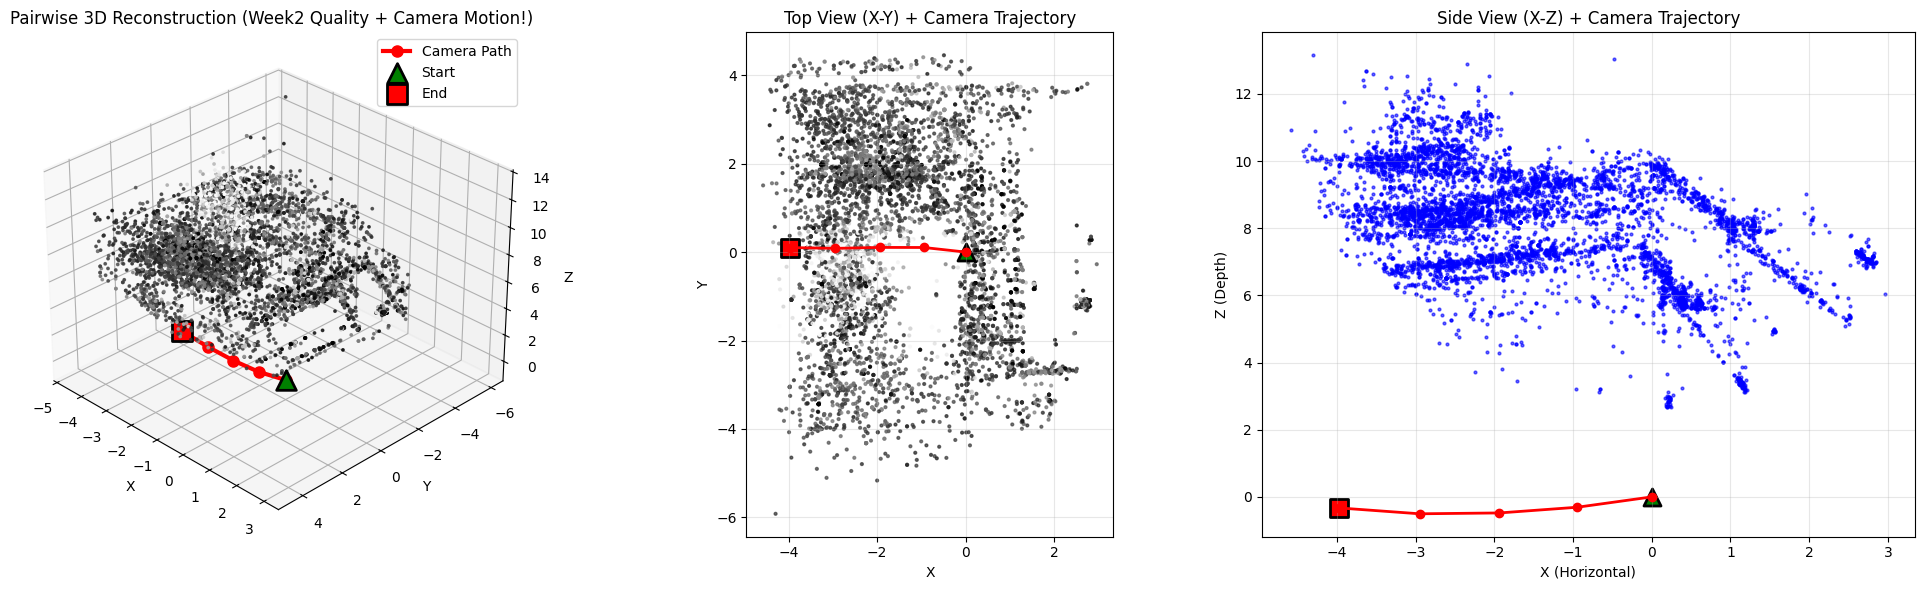

In [6]:
if not USE_BUNDLE_ADJUSTMENT and 'pairwise_points' in locals():
    import matplotlib.pyplot as plt
    
    points_3d = pairwise_points.astype(np.float32)
    colors = pairwise_colors.astype(np.float32) / 255.0
    
    mean = np.mean(points_3d, axis=0)
    std = np.std(points_3d, axis=0)
    clean_mask = (np.abs(points_3d - mean) < 3 * std).all(axis=1)
    clean_points = points_3d[clean_mask]
    colors_clean = colors[clean_mask]
    
    print(f"Visualizing {len(clean_points)} points (removed {len(points_3d) - len(clean_points)} outliers).")
    
    X = clean_points[:, 0]
    Y = clean_points[:, 1]
    Z = clean_points[:, 2]
    
    fig = plt.figure(figsize=(20, 6))
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X, Y, Z, c=colors_clean, s=3, alpha=0.8)
    
    if 'pairwise_cameras' in locals():
        cam_X = pairwise_cameras[:, 0]
        cam_Y = pairwise_cameras[:, 1]
        cam_Z = pairwise_cameras[:, 2]
        ax1.plot(cam_X, cam_Y, cam_Z, 'r-o', linewidth=3, markersize=8, label='Camera Path')
        ax1.scatter(cam_X[0], cam_Y[0], cam_Z[0], c='green', s=200, marker='^', label='Start', edgecolors='black', linewidths=2)
        ax1.scatter(cam_X[-1], cam_Y[-1], cam_Z[-1], c='red', s=200, marker='s', label='End', edgecolors='black', linewidths=2)
        ax1.legend()
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Pairwise 3D Reconstruction (Week2 Quality + Camera Motion!)')
    ax1.invert_yaxis()
    ax1.view_init(elev=30, azim=-45)
    
    ax2 = fig.add_subplot(132)
    ax2.scatter(X, Y, c=colors_clean, s=4, alpha=0.7)
    if 'pairwise_cameras' in locals():
        ax2.plot(cam_X, cam_Y, 'r-o', linewidth=2, markersize=6)
        ax2.scatter(cam_X[0], cam_Y[0], c='green', s=150, marker='^', edgecolors='black', linewidths=2)
        ax2.scatter(cam_X[-1], cam_Y[-1], c='red', s=150, marker='s', edgecolors='black', linewidths=2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Top View (X-Y) + Camera Trajectory')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='box')
    
    ax3 = fig.add_subplot(133)
    ax3.scatter(X, Z, c='blue', s=4, alpha=0.6)
    if 'pairwise_cameras' in locals():
        ax3.plot(cam_X, cam_Z, 'r-o', linewidth=2, markersize=6)
        ax3.scatter(cam_X[0], cam_Z[0], c='green', s=150, marker='^', edgecolors='black', linewidths=2)
        ax3.scatter(cam_X[-1], cam_Z[-1], c='red', s=150, marker='s', edgecolors='black', linewidths=2)
    ax3.set_xlabel('X (Horizontal)')
    ax3.set_ylabel('Z (Depth)')
    ax3.set_title('Side View (X-Z) + Camera Trajectory')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    del points_3d, clean_points, colors, colors_clean, X, Y, Z
    gc.collect()
else:
    if USE_BUNDLE_ADJUSTMENT:
        print("✓ Pairwise visualization skipped (using incremental SfM path).")
    else:
        print("⚠️  Run the pairwise reconstruction cell first!")

# Open3D: Pairwise Reconstruction

In [7]:
if not USE_BUNDLE_ADJUSTMENT and 'pairwise_points' in locals():
    try:
        import open3d as o3d
        import matplotlib.pyplot as plt
        
        print("Loading pairwise reconstruction into Open3D...")
        
        pts = pairwise_points.astype(np.float64)
        cols = pairwise_colors.astype(np.float64) / 255.0
        
        valid_mask = np.isfinite(pts).all(axis=1)
        pts = pts[valid_mask]
        cols = cols[valid_mask]
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts)
        pcd.colors = o3d.utility.Vector3dVector(cols)
        
        if len(pts) > 1000:
            cl, ind = pcd.remove_statistical_outlier(nb_neighbors=30, std_ratio=1.5)
            pcd = cl
            print(f'Filtered to {len(pcd.points)} points (removed {len(pts) - len(pcd.points)} outliers).')
        
        bbox = pcd.get_axis_aligned_bounding_box()
        bbox.color = (1, 0.4, 0.0)
        axes_size = max(bbox.get_extent()) or 1.0
        axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.4 * axes_size, origin=bbox.get_center())
        
        print(f"\n✨ Launching Open3D viewer for PAIRWISE reconstruction...")
        print(f"   This should look as good as Week2! 🎯\n")
        
        o3d.visualization.draw_geometries(
            [pcd, bbox, axes],
            window_name='Pairwise Reconstruction (Week2 Quality)',
            width=1400,
            height=1000,
            left=50,
            top=50,
            point_show_normal=False
        )
        
        del pts, cols, pcd
        gc.collect()
        
    except ImportError:
        print('⚠️  Open3D not installed. Run: pip install open3d')
    except Exception as e:
        print(f'⚠️  Open3D visualization failed: {e}')
else:
    if USE_BUNDLE_ADJUSTMENT:
        print("✓ Pairwise Open3D skipped (using incremental SfM path).")
    else:
        print("⚠️  Run the pairwise reconstruction cell first!")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Loading pairwise reconstruction into Open3D...
Filtered to 5975 points (removed 68 outliers).

✨ Launching Open3D viewer for PAIRWISE reconstruction...
   This should look as good as Week2! 🎯



# Matplotlib Visualization

In [8]:
if USE_BUNDLE_ADJUSTMENT:
    import matplotlib.pyplot as plt
    
    print(f"Preparing visualization for {len(sfm.point_cloud)} points...")
    
    points_3d = np.array(sfm.point_cloud, dtype=np.float32)
    colors = None
    if hasattr(sfm, 'point_colors') and len(sfm.point_colors) == len(sfm.point_cloud):
        colors = np.array(sfm.point_colors, dtype=np.float32) / 255.0
    
    mean = np.mean(points_3d, axis=0)
    std = np.std(points_3d, axis=0)
    clean_mask = (np.abs(points_3d - mean) < 3 * std).all(axis=1)
    clean_points = points_3d[clean_mask]
    colors_clean = colors[clean_mask] if colors is not None else None
    
    print(f"Visualizing {len(clean_points)} points (removed {len(points_3d) - len(clean_points)} outliers).")
    
    X = clean_points[:, 0]
    Y = clean_points[:, 1]
    Z = clean_points[:, 2]
    
    fig = plt.figure(figsize=(18, 6))
    
    ax1 = fig.add_subplot(131, projection='3d')
    if colors_clean is not None:
        ax1.scatter(X, Y, Z, c=colors_clean, s=4, alpha=0.85)
    else:
        scatter = ax1.scatter(X, Y, Z, c=Z, cmap='viridis', s=3, alpha=0.7)
        plt.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title('Incremental SfM 3D Point Cloud')
    ax1.invert_yaxis()
    ax1.view_init(elev=30, azim=-45)
    
    ax2 = fig.add_subplot(132)
    if colors_clean is not None:
        ax2.scatter(X, Y, c=colors_clean, s=6, alpha=0.8)
    else:
        ax2.scatter(X, Y, c=Z, cmap='viridis', s=6, alpha=0.8)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('2D Scatter (X-Y)')
    ax2.grid(True, alpha=0.3)
    ax2.set_aspect('equal', adjustable='box')
    
    ax3 = fig.add_subplot(133)
    ax3.scatter(X, Z, c='blue', s=6, alpha=0.6)
    ax3.set_xlabel('X (Horizontal)')
    ax3.set_ylabel('Z (Depth)')
    ax3.set_title('Top-Down (X-Z)')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    del points_3d, clean_points, X, Y, Z
    if colors is not None:
        del colors, colors_clean
    gc.collect()
else:
    print("✓ Incremental SfM visualization skipped (using pairwise path).")

✓ Incremental SfM visualization skipped (using pairwise path).


# Interactive 3D Visualization (Open3D)

In [9]:
if USE_BUNDLE_ADJUSTMENT:
    try:
        import open3d as o3d
        import matplotlib.pyplot as plt
        import os
    
        use_refined = os.path.exists('reconstruction_refined.ply')
        ply_path = 'reconstruction_refined.ply' if use_refined else 'reconstruction_raw.ply'
        
        print(f"Loading point cloud from {ply_path}...")
    
        pts = np.array(sfm.point_cloud, dtype=np.float64)
        
        valid_mask = np.isfinite(pts).all(axis=1)
        if not np.any(valid_mask):
            raise RuntimeError('All reconstructed points are invalid (NaN/Inf).')
        pts = pts[valid_mask]
        
        colors = None
        if sfm.point_colors:
            colors = np.array(sfm.point_colors, dtype=np.float64)[valid_mask[:len(sfm.point_colors)]]
            colors = colors / 255.0 if colors.max() > 1.0 else colors
    
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pts)
        
        if colors is not None:
            pcd.colors = o3d.utility.Vector3dVector(colors)
        else:
            z = pts[:, 2]
            z_norm = (z - z.min()) / max(1e-9, (z.max() - z.min()))
            colors_z = plt.cm.viridis(z_norm)[:, :3]
            pcd.colors = o3d.utility.Vector3dVector(colors_z)
    
        if len(pts) > 2000:
            cl, ind = pcd.remove_statistical_outlier(nb_neighbors=24, std_ratio=2.0)
            pcd = cl
            print(f'Removed {len(pts) - len(pcd.points)} statistical outliers; showing {len(pcd.points)} points.')
        else:
            print(f'Showing {len(pts)} points (no filtering applied).')
    
        bbox = pcd.get_axis_aligned_bounding_box()
        bbox.color = (1, 0.4, 0.0)
        axes_size = max(bbox.get_extent()) or 1.0
        axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5 * axes_size, origin=bbox.get_center())
    
        print(f"\n✨ Launching Open3D interactive viewer...")
        print("Controls:")
        print("  • Left-click + drag = Rotate view")
        print("  • Right-click + drag = Pan camera")
        print("  • Scroll wheel = Zoom in/out")
        print("  • Press 'H' = Show all keyboard shortcuts")
        print("  • Press '-' or '+' = Adjust point size\n")
        
        o3d.visualization.draw_geometries(
            [pcd, bbox, axes],
            window_name='Incremental SfM Point Cloud',
            width=1400,
            height=1000,
            left=50,
            top=50,
            point_show_normal=False
        )
        
        del pts, pcd
        if colors is not None:
            del colors
        gc.collect()
        
    except ImportError:
        print('⚠️  Open3D not installed. Run: pip install open3d')
        print('Skipping interactive visualization.')
    except Exception as e:
        print(f'⚠️  Open3D visualization failed: {e}')
        print('This is normal in some environments (e.g., headless servers).')
else:
    print("✓ Incremental SfM Open3D skipped (using pairwise path).")

✓ Incremental SfM Open3D skipped (using pairwise path).
